In [1]:
!pip install music21

In [1]:
from music21 import *
import numpy as np
from collections import Counter
#for listing down the file names
import os

#library for visualiation
import matplotlib.pyplot as plt

from tensorflow import cast
from tensorflow import int64
from tensorflow import float32
#Array Processing
import numpy as np

from sklearn.model_selection import train_test_split
import random

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K

from tensorflow.keras.models import load_model

Convert MIDI into an array of notes

In [10]:
def read_midi(file):
    
#     print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts: 

        notes_to_parse = part.recurse() 

        #finding whether a particular element is note or a chord
        for element in notes_to_parse:

            #note
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))

            #chord
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

For each MIDI, convert that MIDI into a Note_Sequence (encoded vector)

In [11]:
def parse_sequence(path):
    #read all the filenames
    files=[i for i in os.listdir(path) if i.endswith(".mid")]

    #reading each midi file
    notes_array = np.array([read_midi(path+i) for i in files], dtype=object)
    
    #converting 2D array into 1D array
    notes_ = [element for note_ in notes_array for element in note_]

    #No. of unique notes
    unique_notes = list(set(notes_))
#     print(len(unique_notes))
    
    #computing frequency of each note
    freq = dict(Counter(notes_))


    #consider only the frequencies
    no=[count for _,count in freq.items()]

    #set the figure size
    plt.figure(figsize=(5,5))

    #plot
    plt.hist(no)
    
    frequent_notes = [note_ for note_, count in freq.items() if count>=4]
#     print(len(frequent_notes))

    new_music=[]

    for notes in notes_array:
        temp=[]
        for note_ in notes:
            if note_ in frequent_notes:
                temp.append(note_)            
        new_music.append(temp)

    new_music = np.array(new_music,dtype=object)
    
    no_of_timesteps = 32
    x = []
    y = []

    for note_ in new_music:
        for i in range(0, len(note_) - no_of_timesteps, 1):

            #preparing input and output sequences
            input_ = note_[i:i + no_of_timesteps]
            output = note_[i + no_of_timesteps]

            x.append(input_)
            y.append(output)

    x=np.array(x)
    y=np.array(y)
    unique_x = list(set(x.ravel()))
    x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))
    
    x_seq=[]
    for i in x:
        temp=[]
        for j in i:
            #assigning unique integer to every note
            temp.append(x_note_to_int[j])
        x_seq.append(temp)

    x_seq = np.array(x_seq)
    
    unique_y = list(set(y))
    y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
    y_seq=np.array([y_note_to_int[i] for i in y])
    
    return x_seq, y_seq, unique_x, unique_y

LTSM Model, recommended model

In [12]:
def lstm(unique_y):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(len(unique_y)))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    return model

CONV1D used for WAVEFORM but works with symbolic music

In [13]:
def create_conv(unique_x, unique_y):

    model = Sequential()
    
    print(len(unique_x))
    #embedding layer
    model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 
    model.add(Conv1D(64,3, activation='relu', padding='causal'))
    model.add(Dropout(0.2))
    model.add(MaxPool1D(2))

    model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
    model.add(Dropout(0.2))
    model.add(MaxPool1D(2))

    model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
    model.add(Dropout(0.2))
    model.add(MaxPool1D(2))

    #model.add(Conv1D(256,5,activation='relu'))    
    model.add(GlobalMaxPool1D())

    model.add(Dense(256, activation='relu'))
    model.add(Dense(len(unique_y), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    
    return model


Convert Model Predictions into a MIDI file

In [14]:
def convert_to_midi(prediction_output,outputname):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=f'{outputname}.mid')

Compile each model with the note sequences and make a generated sequence

In [15]:
def compile_and_generate(model, best_model, x_seq, y_seq, unique_x):
    
    x_tr, fakex_val, y_tr, fakey_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)
    x_val, x_test, y_val, y_test = train_test_split(fakex_val,fakey_val,test_size=0.5,random_state=0)
    
    mc=ModelCheckpoint(best_model, monitor='val_loss', mode='min', save_best_only=True,verbose=1)
    history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])
#     history = model.fit(x_tr,y_tr,batch_size=128,epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])
    
    model = load_model(best_model)
    
    
    ind = np.random.randint(0,len(x_test)-1)

    random_music = x_test[ind]

    predictions=[]
    for i in range(10):
        
        if "lstm" in best_model:
             random_music = random_music.reshape(1, 32, 1)
        else:
            
            random_music = random_music.reshape(1, 32)

        prob  = model.predict(random_music)[0]
        y_pred= np.argmax(prob,axis=0)
        predictions.append(y_pred)

        random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
        random_music = random_music[1:]

    print(predictions)
    
    x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
    predicted_notes = [x_int_to_note[i] for i in predictions]
    
    convert_to_midi(predicted_notes, best_model)
    

(1114, 32)
Epoch 1/50
7/7 [==============================] - 5s 275ms/step - loss: 3.1326 - val_loss: 2.2365

Epoch 00001: val_loss improved from inf to 2.23648, saving model to drum_lstm.h5
Epoch 2/50
7/7 [==============================] - 1s 147ms/step - loss: 2.3325 - val_loss: 1.7706

Epoch 00002: val_loss improved from 2.23648 to 1.77060, saving model to drum_lstm.h5
Epoch 3/50
7/7 [==============================] - 1s 144ms/step - loss: 1.9074 - val_loss: 1.6001

Epoch 00003: val_loss improved from 1.77060 to 1.60014, saving model to drum_lstm.h5
Epoch 4/50
7/7 [==============================] - 1s 142ms/step - loss: 1.7410 - val_loss: 1.3330

Epoch 00004: val_loss improved from 1.60014 to 1.33296, saving model to drum_lstm.h5
Epoch 5/50
7/7 [==============================] - 1s 143ms/step - loss: 1.4227 - val_loss: 1.2074

Epoch 00005: val_loss improved from 1.33296 to 1.20745, saving model to drum_lstm.h5
Epoch 6/50
7/7 [==============================] - 1s 187ms/step - loss: 1

7/7 [==============================] - 1s 148ms/step - loss: 0.5431 - val_loss: 0.7000

Epoch 00050: val_loss did not improve from 0.68721
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


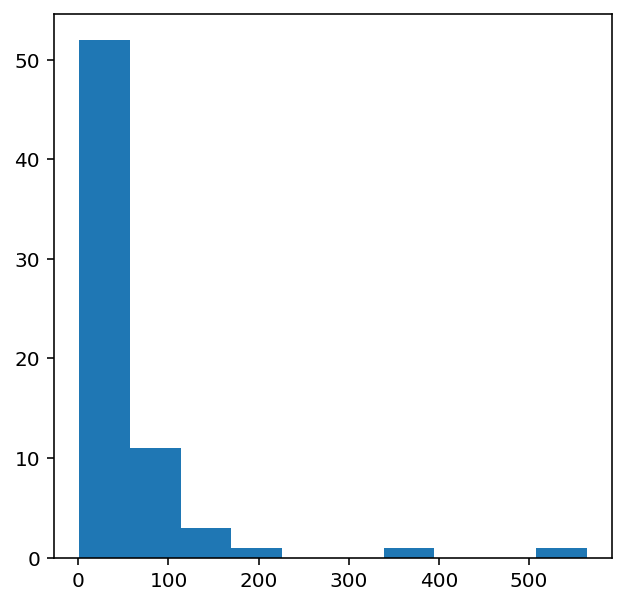

In [19]:
#specify the path for training the drums
path='DRUMS/'

xseq, yseq, unique_x, unique_y = parse_sequence(path)
print(xseq.shape)
xseq= xseq.reshape(1114, 32, 1)
xseq = xseq.astype(np.float32)

compile_and_generate(lstm(unique_y), "drum_lstm.h5", xseq, yseq, unique_x)

33
Epoch 1/50
7/7 [==============================] - 1s 77ms/step - loss: 3.4340 - val_loss: 3.0490

Epoch 00001: val_loss improved from inf to 3.04897, saving model to drum_conv.h5
Epoch 2/50
7/7 [==============================] - 0s 51ms/step - loss: 2.4165 - val_loss: 1.4685

Epoch 00002: val_loss improved from 3.04897 to 1.46847, saving model to drum_conv.h5
Epoch 3/50
7/7 [==============================] - 0s 65ms/step - loss: 1.5995 - val_loss: 1.2589

Epoch 00003: val_loss improved from 1.46847 to 1.25895, saving model to drum_conv.h5
Epoch 4/50
7/7 [==============================] - 0s 51ms/step - loss: 1.3919 - val_loss: 1.0887

Epoch 00004: val_loss improved from 1.25895 to 1.08868, saving model to drum_conv.h5
Epoch 5/50
7/7 [==============================] - 0s 50ms/step - loss: 1.1136 - val_loss: 0.9838

Epoch 00005: val_loss improved from 1.08868 to 0.98378, saving model to drum_conv.h5
Epoch 6/50
7/7 [==============================] - 0s 49ms/step - loss: 0.9908 - val_lo

7/7 [==============================] - 0s 55ms/step - loss: 0.4400 - val_loss: 0.6157

Epoch 00050: val_loss did not improve from 0.58890
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


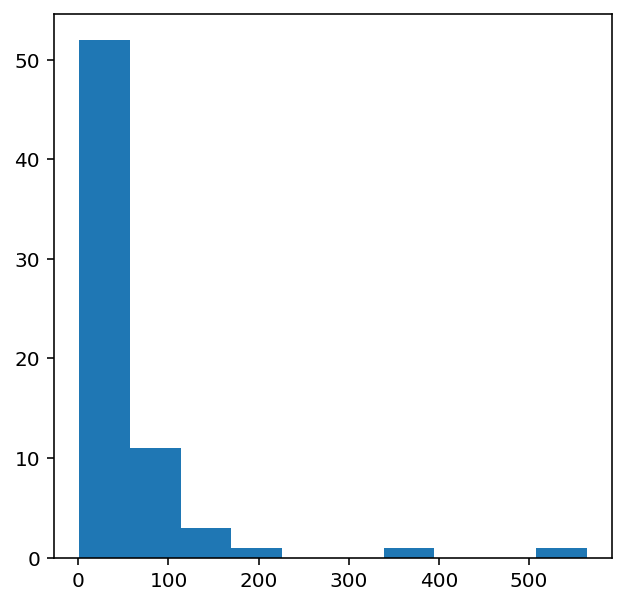

In [20]:
path='DRUMS/'

xseq, yseq, unique_x, unique_y = parse_sequence(path)

compile_and_generate(create_conv(unique_x,unique_y), "drum_conv.h5", xseq, yseq, unique_x)

(82160, 32)
Epoch 1/50
514/514 [==============================] - 80s 148ms/step - loss: 4.8905 - val_loss: 4.6481

Epoch 00001: val_loss improved from inf to 4.64806, saving model to piano_lstm.h5
Epoch 2/50
514/514 [==============================] - 85s 165ms/step - loss: 4.5858 - val_loss: 4.4887

Epoch 00002: val_loss improved from 4.64806 to 4.48868, saving model to piano_lstm.h5
Epoch 3/50
514/514 [==============================] - 77s 151ms/step - loss: 4.4055 - val_loss: 4.3352

Epoch 00003: val_loss improved from 4.48868 to 4.33523, saving model to piano_lstm.h5
Epoch 4/50
514/514 [==============================] - 77s 150ms/step - loss: 4.2229 - val_loss: 4.1887

Epoch 00004: val_loss improved from 4.33523 to 4.18869, saving model to piano_lstm.h5
Epoch 5/50
514/514 [==============================] - 70s 137ms/step - loss: 4.0355 - val_loss: 4.0746

Epoch 00005: val_loss improved from 4.18869 to 4.07459, saving model to piano_lstm.h5
Epoch 6/50
514/514 [======================

514/514 [==============================] - 74s 145ms/step - loss: 1.1452 - val_loss: 4.0279

Epoch 00050: val_loss did not improve from 3.43700
[215, 56, 215, 56, 215, 56, 215, 56, 215, 56]


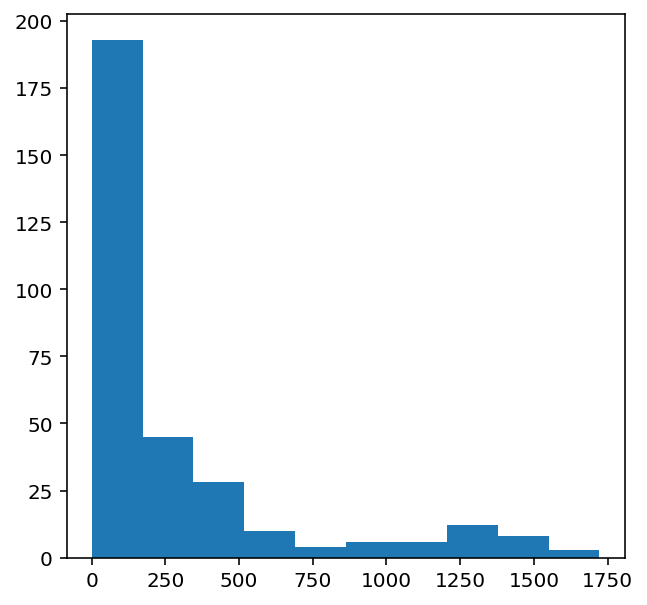

In [22]:
path='PIANO/'

xseq, yseq, unique_x, unique_y = parse_sequence(path)
print(xseq.shape)
xseq= xseq.reshape(82160, 32, 1)
xseq = xseq.astype(np.float32)

compile_and_generate(lstm(unique_y), "piano_lstm.h5", xseq, yseq, unique_x)

269
Epoch 1/50
514/514 [==============================] - 21s 39ms/step - loss: 4.7414 - val_loss: 4.1068

Epoch 00001: val_loss improved from inf to 4.10681, saving model to piano_conv.h5
Epoch 2/50
514/514 [==============================] - 20s 40ms/step - loss: 3.8922 - val_loss: 3.9052

Epoch 00002: val_loss improved from 4.10681 to 3.90516, saving model to piano_conv.h5
Epoch 3/50
514/514 [==============================] - 20s 40ms/step - loss: 3.6839 - val_loss: 3.7997

Epoch 00003: val_loss improved from 3.90516 to 3.79973, saving model to piano_conv.h5
Epoch 4/50
514/514 [==============================] - 20s 40ms/step - loss: 3.5353 - val_loss: 3.6485

Epoch 00004: val_loss improved from 3.79973 to 3.64852, saving model to piano_conv.h5
Epoch 5/50
514/514 [==============================] - 20s 39ms/step - loss: 3.4185 - val_loss: 3.5614

Epoch 00005: val_loss improved from 3.64852 to 3.56138, saving model to piano_conv.h5
Epoch 6/50
514/514 [==============================] - 2

514/514 [==============================] - 18s 36ms/step - loss: 2.4433 - val_loss: 2.8831

Epoch 00046: val_loss improved from 2.88420 to 2.88307, saving model to piano_conv.h5
Epoch 47/50
514/514 [==============================] - 18s 36ms/step - loss: 2.4445 - val_loss: 2.8783

Epoch 00047: val_loss improved from 2.88307 to 2.87834, saving model to piano_conv.h5
Epoch 48/50
514/514 [==============================] - 18s 36ms/step - loss: 2.4391 - val_loss: 2.8630

Epoch 00048: val_loss improved from 2.87834 to 2.86302, saving model to piano_conv.h5
Epoch 49/50
514/514 [==============================] - 19s 36ms/step - loss: 2.4264 - val_loss: 2.8832

Epoch 00049: val_loss did not improve from 2.86302
Epoch 50/50
514/514 [==============================] - 18s 36ms/step - loss: 2.4229 - val_loss: 2.8722

Epoch 00050: val_loss did not improve from 2.86302
[70, 5, 70, 5, 70, 5, 173, 5, 173, 233]


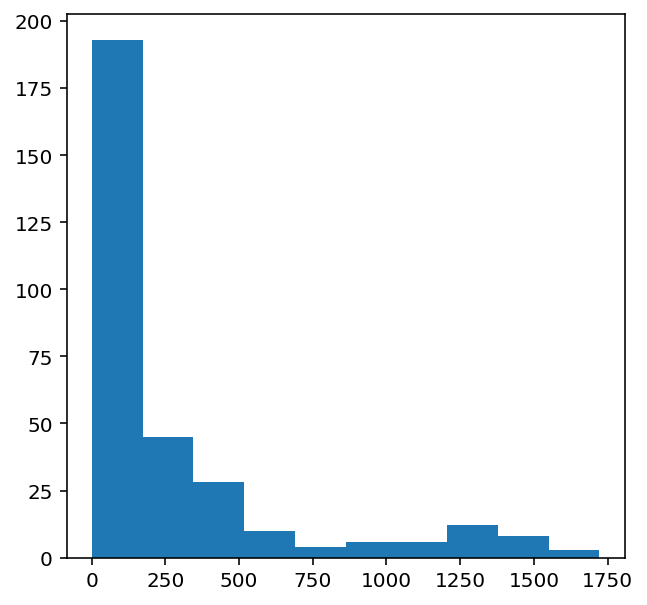

In [24]:
path='PIANO/'

xseq, yseq, unique_x, unique_y = parse_sequence(path)

compile_and_generate(create_conv(unique_x,unique_y), "piano_conv.h5", xseq, yseq, unique_x)